In [ ]:
!pip install opencv-python
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


**IMPORTING** LIBRARIES

In [ ]:
# importing necessary libraries
import kagglehub
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision,Recall
import kerastuner as kt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


<ipython-input-2-3f44911a7924>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


# Exploratory Data Analysis(EDA)

In [ ]:

# Define source and destination paths
source_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
destination_path = "/content"

# Copy the dataset to /content for easier access or to allow modifications
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Dataset copied to:", destination_path)


Dataset copied to: /content


In [ ]:
# checking the folderrs in the dataset
def check_class(dataset_path):  # Update if you moved it elsewhere
    if os.path.exists(dataset_path):
        print("✅ Dataset found at:", dataset_path)
        print("📂 Files inside dataset:", os.listdir(dataset_path))
    else:
        print("❌ Dataset not found. Check the path.")

In [ ]:
check_class("/content/brain_tumor_dataset")

✅ Dataset found at: /content/brain_tumor_dataset
📂 Files inside dataset: ['yes', 'no']


In [ ]:

# Define dataset path
d_path = "/content/brain_tumor_dataset"

# List tumor categories
path_category = ["no", "yes"]

# Count images in each category
for img in path_category:
    folder_path = os.path.join(d_path, img)
    num_images = len(os.listdir(folder_path)) if os.path.exists(folder_path) else 0
    print(f"📂 {img}: {num_images} images")



📂 no: 98 images
📂 yes: 155 images


In [ ]:
import os
import pandas as pd
from PIL import Image

def load_df(path):
    classes = []
    class_paths = []
    invalid_images = []  # To store invalid image paths

    for label in os.listdir(path):
        label_path = os.path.join(path, label)

        # Check if it's a directory (i.e., a class folder)
        if os.path.isdir(label_path):
            try:
                for image in os.listdir(label_path):
                    image_path = os.path.join(label_path, image)

                    # Only add image files
                    if os.path.isfile(image_path):
                        # Check if the image is valid
                        try:
                            with Image.open(image_path) as img:
                                img.verify()  # Verify if the image is intact
                            classes.append(label)
                            class_paths.append(image_path)
                        except (IOError, SyntaxError) as e:
                            invalid_images.append(image_path)  # Log invalid image path
            except Exception as e:
                print(f"Error processing folder {label}: {e}")

    # Create DataFrame with class paths and labels
    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})

    # Report invalid images
    if invalid_images:
        print("The following images are invalid or corrupted:")
        for img_path in invalid_images:
            print(f"Invalid Image: {img_path}")

    return df


In [ ]:
load_df("/content/brain_tumor_dataset")

,Class Path,Class
0,/content/brain_tumor_dataset/yes/Y109.JPG,yes
1,/content/brain_tumor_dataset/yes/Y183.jpg,yes
2,/content/brain_tumor_dataset/yes/Y18.JPG,yes
3,/content/brain_tumor_dataset/yes/Y71.JPG,yes
4,/content/brain_tumor_dataset/yes/Y70.jpg,yes
...,...,...
248,/content/brain_tumor_dataset/no/N2.JPG,no
249,/content/brain_tumor_dataset/no/No11.jpg,no
250,/content/brain_tumor_dataset/no/31 no.jpg,no
251,/content/brain_tumor_dataset/no/24 no.jpg,no


In [ ]:
import os
from PIL import Image

def check_invalid_images(path):
    invalid_images = []  # List to store invalid image paths

    for label in os.listdir(path):
        label_path = os.path.join(path, label)

        # Check if it's a directory (i.e., a class folder)
        if os.path.isdir(label_path):
            try:
                for image in os.listdir(label_path):
                    image_path = os.path.join(label_path, image)

                    # Only check image files (optional, depending on your needs)
                    if os.path.isfile(image_path):
                        try:
                            # Attempt to open and verify the image
                            with Image.open(image_path) as img:
                                img.verify()  # Verify image integrity
                        except (IOError, SyntaxError) as e:
                            invalid_images.append(image_path)  # Log invalid image path
            except Exception as e:
                print(f"Error processing folder {label}: {e}")

    # Return the list of invalid images
    return invalid_images




In [ ]:
check_invalid_images("/content/brain_tumor_dataset")

[]

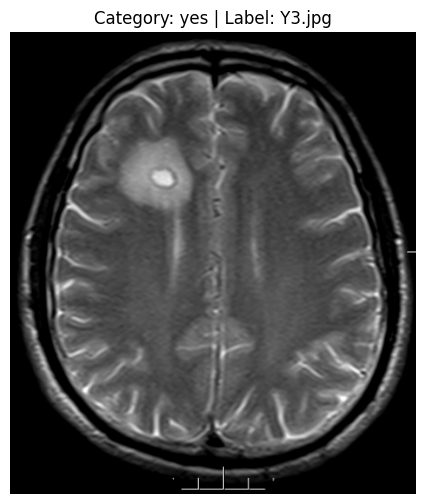

In [ ]:
#  funntion that displays requested image

def display_image(folder_name, image_name, base_path="/content/brain_tumor_dataset"):
    """
    Displays a random image from a given folder (category) with its label.

    Parameters:
    - folder_name (str): Name of the category folder (e.g., "glioma", "meningioma").
    - label (str): Label for the image (e.g., "Tumor" or "No Tumor").
    - base_path (str): Root path where the dataset is stored (default is train path).
    """
    # Construct the full path to the folder
    folder_path = os.path.join(base_path, folder_name)
    image_path = os.path.join(folder_path,image_name)


    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"❌ Error: Folder '{folder_name}' not found at '{folder_path}'.")
        return

    # Get list of images in the folder
    images = os.listdir(folder_path)

    if len(images) == 0:
        print(f"⚠️ No images found in '{folder_name}' folder.")
        return


    # Load image with OpenCV (convert BGR to RGB)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Category: {folder_name} | Label: {image_name}")
    plt.axis("off")
    plt.show()
display_image("yes", "Y3.jpg")

In [ ]:
  # Progress bar

def preprocess_images_in_place(folder_path, target_size=(224, 224)):
    """
    Resizes all images in folder_path to target_size and saves them in the same location.

    Parameters:
    - folder_path (str): Path to main dataset folder (e.g., 'dataset/')
    - target_size (tuple): Target image size (default is 224x224)
    """

    # Loop through all category folders
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)

        if not os.path.isdir(category_path):
            continue  # Skip if it's not a folder

        # Process each image in the category folder
        for image_name in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            image_path = os.path.join(category_path, image_name)

            # Read image
            img = cv2.imread(image_path)
            if img is None:
                print(f"⚠️ Skipping {image_name} (corrupt or unreadable)")
                continue

            # Convert to RGB (if grayscale)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image
            img = cv2.resize(img, target_size)

            # Overwrite the original image with the resized one
            cv2.imwrite(image_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print("✅ Preprocessing complete! All images resized in place.")

# Example usage
preprocess_images_in_place("/content/brain_tumor_dataset")


Processing no: 100%|██████████| 98/98 [00:00<00:00, 561.38it/s]

✅ Preprocessing complete! All images resized in place.


In [ ]:
# making sure all the imges were successful
img = cv2.imread("/content/brain_tumor_dataset/yes/Y104.jpg")
print(img.shape)

(224, 224, 3)


In [ ]:

from sklearn.model_selection import train_test_split

def split_data(path, train_size=0.8, val_size=0.2, output_dir='split_data'):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create subdirectories for train and validation sets
    for subset in ['train', 'val']:
        subset_path = os.path.join(output_dir, subset)
        if not os.path.exists(subset_path):
            os.makedirs(subset_path)

    # Collect image paths and labels
    image_paths = []
    labels = []

    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    # Split into train and validation
    train_paths, val_paths = train_test_split(image_paths, train_size=train_size, stratify=labels, random_state=42)

    # Function to move images to their respective directories
    def move_images(image_paths, subset):
        for image_path in image_paths:
            # Extract the label from the image path (parent directory name)
            label = os.path.basename(os.path.dirname(image_path))
            # Create the label directory inside the subset folder
            label_dir = os.path.join(output_dir, subset, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
            # Move the image to the appropriate folder
            shutil.copy(image_path, os.path.join(label_dir, os.path.basename(image_path)))

    # Move the images to the respective train and val directories
    move_images(train_paths, 'train')
    move_images(val_paths, 'val')

    print(f"Data split complete. Training set: {len(train_paths)} images, Validation set: {len(val_paths)} images.")

# Example usage
split_data('/content/brain_tumor_dataset', train_size=0.8, val_size=0.2, output_dir='/content/brain_tumor_dataset/split_data')



Data split complete. Training set: 202 images, Validation set: 51 images.


Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



# Set up ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Increased range for rotations
    width_shift_range=0.3,  # Increased range for width shift
    height_shift_range=0.3,  # Increased range for height shift
    shear_range=0.3,  # Increased shear range
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Set the path for the train and val directories
train_dir = '/content/brain_tumor_dataset/split_data/train'
val_dir = '/content/brain_tumor_dataset/split_data/val'

# Load the images using flow_from_directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary'  # Since it’s a binary classification (brain tumor or not)
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary'
)


# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_brain_tumor.h5', monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6035 - loss: 0.7302

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6048 - loss: 0.7294 - val_accuracy: 0.6863 - val_loss: 0.6321
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5565 - loss: 0.6850

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.5600 - loss: 0.6861 - val_accuracy: 0.7255 - val_loss: 0.5658
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6677 - loss: 0.5963

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - accuracy: 0.6622 - loss: 0.6037 - val_accuracy: 0.7451 - val_loss: 0.5488
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7696 - loss: 0.5176

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.7613 - loss: 0.5238 - val_accuracy: 0.8039 - val_loss: 0.4989
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.6401 - loss: 0.5991 - val_accuracy: 0.7647 - val_loss: 0.4958
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.7148 - loss: 0.5775 - val_accuracy: 0.7255 - val_loss: 0.4885
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step - accuracy: 0.6861 - loss: 0.5923 - val_accuracy: 0.7843 - val_loss: 0.4799
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.7582 - loss: 0.5425 - val_accuracy: 0.7451 - val_loss: 0.4939
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7065 - loss: 0.5335

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.7098 - loss: 0.5323 - val_accuracy: 0.8235 - val_loss: 0.4472
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.7609 - loss: 0.5059 - val_accuracy: 0.8039 - val_loss: 0.4424
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step - accuracy: 0.7829 - loss: 0.4870 - val_accuracy: 0.7059 - val_loss: 0.4890
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.6951 - loss: 0.5470 - val_accuracy: 0.8235 - val_loss: 0.4127
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7771 - loss: 0.4554

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.7765 - loss: 0.4533 - val_accuracy: 0.8431 - val_loss: 0.3871
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - accuracy: 0.8022 - loss: 0.4536 - val_accuracy: 0.7647 - val_loss: 0.4661
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.7290 - loss: 0.5230 - val_accuracy: 0.8235 - val_loss: 0.3758
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.8168 - loss: 0.4354 - val_accuracy: 0.8235 - val_loss: 0.4003
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7980 - loss: 0.4212

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.7954 - loss: 0.4215 - val_accuracy: 0.8824 - val_loss: 0.3807
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.7759 - loss: 0.4270 - val_accuracy: 0.8824 - val_loss: 0.3649
Epoch 19/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.8668 - loss: 0.3499 - val_accuracy: 0.8431 - val_loss: 0.3914
Epoch 20/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7811 - loss: 0.4248

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - accuracy: 0.7831 - loss: 0.4209 - val_accuracy: 0.9608 - val_loss: 0.3381


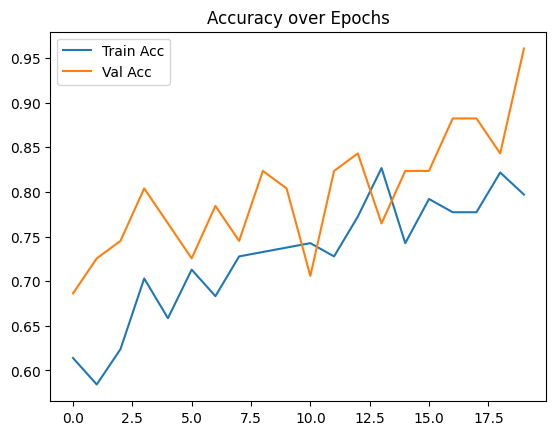

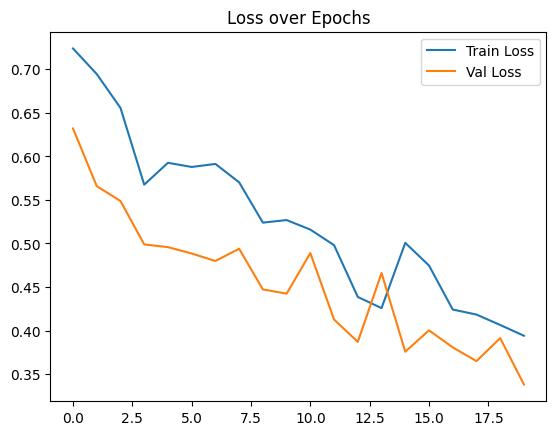

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()


In [ ]:
# Save the trained model
model.save('brain_tumor_detection_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('mobilenetv2_brain_tumor.h5')


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    result = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return result, confidence

# Example
result, confidence = predict_image("/content/gli_0000.jpeg")
print(f"Prediction: {result} ({confidence * 100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: Tumor (52.14% confidence)


In [ ]:
# # tried training with VGG 16
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import GlobalAveragePooling2D
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )


# # ✅ Load Training Data
# train_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='training'
# )

# # ✅ Load Validation Data
# val_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='validation'
# )
# # Loading the VGG16
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# # base_model.trainable = False  # Freeze the pretrained layers
# # Unfreeze some layers(5)
# for layer in base_model.layers[-5:]:
#     layer.trainable = True

# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(512, activation='relu'),
#     Dropout(0.6),
#     Dense(train_data.num_classes, activation='softmax')
# ])
# optimizer = Adam(learning_rate=5e-4)
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',  # ✅ Multi-class loss function
#     metrics=['accuracy']
# )
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1)

# # 🔹 Train the Model
# model.fit(train_data, validation_data=val_data, epochs=25,verbose=2,shuffle = True,batch_size = 64,callbacks=[lr_scheduler])

# # 🔹 Save Model to Google Drive
# model.save('/content/dataset/model_02.h5')
# print("✅ Model saved successfully!")


In [ ]:
# # hyperparameter tuning with keras-tuner
# import keras_tuner as kt  # KerasTuner for tuning
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow import keras

# def build_model(hp):
#     model = Sequential()

#     # Tune the number of filters and kernel size in the first Conv2D layer
#     model.add(Conv2D(
#         filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
#         kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
#         activation='relu',
#         input_shape=(224, 224, 3)
#     ))
#     model.add(MaxPooling2D(pool_size=2))

#     # Second Conv2D Layer
#     model.add(Conv2D(
#         filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
#         kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=2))

#     # Third Conv2D Layer
#     model.add(Conv2D(
#         filters=hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
#         kernel_size=hp.Choice('conv3_kernel', values=[3, 5]),
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=2))

#     model.add(Flatten())

#     # Tune number of neurons in Dense layer
#     model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
#     model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)))

#     # Output layer
#     model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

#     # Tune learning rate
#     model.compile(
#         optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [ ]:
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )


# # ✅ Load Training Data
# train_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='training'
# )

# # ✅ Load Validation Data
# val_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='validation'
# )

In [ ]:
# # Hyperparameter tuning with KerasTuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',  # Optimize for validation accuracy
#     max_trials=10,  # Number of different hyperparameter sets to try
#     executions_per_trial=1,  # Run each model once
#     directory='hyperparam_tuning',
#     project_name='brain_tumor_cnn'
# )

In [ ]:
# tuner.search(train_data, validation_data=val_data, epochs=10)


In [ ]:
# # Trained with a CNN model
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras import mixed_precision

# mixed_precision.set_global_policy('mixed_float16')
# # 🔹 Data Preprocessing (Multi-Class Classification)
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )


# # ✅ Load Training Data
# train_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(128, 128),
#     batch_size=4,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='training'
# )

# # ✅ Load Validation Data
# val_data = datagen.flow_from_directory(
#     '/content/dataset/Training',
#     target_size=(128, 128),
#     batch_size=4,
#     class_mode='categorical',  # ✅ Multi-class classification
#     subset='validation'
# )

# # print("Training class indices:", train_data.class_indices)
# # print("Validation class indices:", val_data.class_indices)

# # print("Total Training Images:", train_data.samples)
# # print("Total Validation Images:", val_data.samples)

# # 🔹 CNN Model
# model = Sequential([
#     Conv2D(96, (3,3), activation='relu', input_shape=(128,128,3)),


#     Conv2D(192, (3,3), activation='relu'),
#     MaxPooling2D(2,2),

#     Conv2D(512, (5,5), activation='relu'),
#     MaxPooling2D(2,2),

#     # Conv2D(128, (3,3), activation='relu'),
#     # MaxPooling2D(2,2),

#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(train_data.num_classes, activation='softmax')  # ✅ Multi-class output

# ])

# # 🔹 Compile the Model
# optimizer = Adam(learning_rate=0.001)
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',  # ✅ Multi-class loss function
#     metrics=['accuracy']
# )
# lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)

# # 🔹 Train the Model
# model.fit(train_data, validation_data=val_data, epochs=30,verbose=2,shuffle = True,batch_size = 4,callbacks=[lr_scheduler])

# # 🔹 Save Model to Google Drive
# model.save('/content/dataset/model09.h5')
# print("✅ Model saved successfully!")


In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# 🔹 Best Hyperparameters Found:
# - Conv1 Filters: {best_hps.get('conv1_filters')}
# - Conv1 Kernel: {best_hps.get('conv1_kernel')}
# - Conv2 Filters: {best_hps.get('conv2_filters')}
# - Conv2 Kernel: {best_hps.get('conv2_kernel')}
# - Conv3 Filters: {best_hps.get('conv3_filters')}
# - Conv3 Kernel: {best_hps.get('conv3_kernel')}
# - Dense Units: {best_hps.get('dense_units')}
# - Dropout Rate: {best_hps.get('dropout')}
# - Learning Rate: {best_hps.get('learning_rate')}
# """)

# # Train the best model on full dataset
# best_model = tuner.hypermodel.build(best_hps)
# best_model.fit(train_data, validation_data=val_data, epochs=20)

# # Save the best model
# best_model.save('/content/best_brain_tumor_model_03.h5')
# print("✅ Best Model Saved Successfully!")


In [ ]:
  # KerasTuner for hyperparameter search

# Enable mixed precision (optional, for further memory reduction)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Data Preprocessing with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 8  # Use a small batch size for memory constraints

train_data = datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    '/content/dataset/Training',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Define a hypermodel function to build your model with tunable parameters
def build_model(hp):
    # Load EfficientNetB0 as the base model (frozen for now)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())

    # Tune the number of neurons in the Dense layer
    dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=64)
    model.add(Dense(dense_units, activation='relu'))

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer (number of classes is determined by your dataset)
    model.add(Dense(train_data.num_classes, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-5, 2e-4])
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up KerasTuner with a RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can adjust the number of trials for more extensive search
    executions_per_trial=1,
    directory='efficientnet_tuner',
    project_name='brain_tumor_efficientnet'
)

# Start the hyperparameter search
tuner.search(train_data, validation_data=val_data, epochs=20, verbose=2)

# Retrieve the best hyperparameters found by the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters Found:", best_hps.values)

# Build and train the final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_data, validation_data=val_data, epochs=20, verbose=2)

# Save the final trained model
best_model.save('/content/dataset/best_efficientnet_model.h5')
print("✅ Best EfficientNet Model Trained and Saved Successfully!")


Trial 2 Complete [00h 22m 39s]
val_accuracy: 0.2795793116092682

Best val_accuracy So Far: 0.3838737905025482
Total elapsed time: 00h 45m 50s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
512               |512               |dense_units
0.4               |0.3               |dropout_rate
0.0002            |0.0001            |learning_rate

Epoch 1/20
572/572 - 99s - 173ms/step - accuracy: 0.2665 - loss: 1.4059 - val_accuracy: 0.2796 - val_loss: 1.3843
Epoch 2/20
572/572 - 65s - 114ms/step - accuracy: 0.2792 - loss: 1.3886 - val_accuracy: 0.2796 - val_loss: 1.3863
Epoch 3/20
572/572 - 65s - 113ms/step - accuracy: 0.2680 - loss: 1.3854 - val_accuracy: 0.2796 - val_loss: 1.3837
Epoch 4/20
572/572 - 72s - 126ms/step - accuracy: 0.2792 - loss: 1.3832 - val_accuracy: 0.2796 - val_loss: 1.3835
Epoch 5/20
572/572 - 64s - 111ms/step - accuracy: 0.2750 - loss: 1.3851 - val_accuracy: 0.2796 - val_loss: 1.3834
Epoch 6/20
572/572 - 64s - 112ms/step - accuracy: 0.27

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/dataset/model_09.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator (rescaling only)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset
test_data = test_datagen.flow_from_directory(
    '/content/dataset/Testing',  # Change this to the path of your new dataset
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change if it's multi-class
    shuffle=True,  # No need to shuffle for evaluation
     classes=['glioma', 'meningioma', 'pituitary', 'notumor']

)


In [ ]:
# Evaluate on the new test dataset
loss, accuracy = model.evaluate(test_data)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


In [ ]:


def predict_image(image_path, model, class_names):
    # Load image and preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)  # Get class index
    print(f"Predicted: {class_names[predicted_class]}")

# Example usage
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
predict_image('/content/dataset/Testing/meningioma/Te-me_0200.jpg', model, class_names)
